#Financial Marckets Analytics Projet

## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data

In [2]:
# Load the dataset S&P500 Stocks Dataset
file_path = '/content/stocks_data (1).xlsx'
stock_data = pd.read_excel(file_path, sheet_name='all_stocks_5yr.csv', engine='openpyxl')
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Load the dataset containing the close price history of the S&P500 index
file_path = '/content/PriceHistory_S&P500.xlsx'
dataSNP = pd.read_excel(file_path, sheet_name='Price History')
dataSNP['Date'] = pd.to_datetime(dataSNP['Date'])

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [4]:
dataSNP.head()

,Date,S&P_Price_Close
0,2024-06-07,568.0133
1,2024-06-06,568.0133
2,2024-06-05,568.1328
3,2024-06-04,561.4857
4,2024-06-03,560.6527


In [6]:
stock_data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## Data Exploration

In [6]:
# Filter data for the specific dates
start_date = '2013-02-08'
end_date = '2018-02-07'
start_data = stock_data[data['date'] == start_date]
end_data = stock_data[data['date'] == end_date]

# Merge data to have start and end prices in a single dataframe
merged_data = pd.merge(start_data, end_data, on='Name', suffixes=('_start', '_end'))

# Calculate the percentage change
merged_data['percentage_change'] = ((merged_data['close_end'] - merged_data['close_start']) / merged_data['close_start']) * 100

# Get the 5 stocks with the highest increase
top_5_increase = merged_data.nlargest(5, 'percentage_change')

# Get the 5 stocks with the highest decrease
top_5_decrease = merged_data.nsmallest(5, 'percentage_change')

# Display the results
print("Top 5 Stocks with the Highest Increase:")
print(top_5_increase[['Name', 'close_start', 'close_end', 'percentage_change']])

print("\nTop 5 Stocks with the Highest Decrease:")
print(top_5_decrease[['Name', 'close_start', 'close_end', 'percentage_change']])


Top 5 Stocks with the Highest Increase:
     Name  close_start  close_end  percentage_change
325  NVDA      12.3700     228.80        1749.636217
313  NFLX      25.8528     264.56         923.332096
25   ALGN      32.7300     234.33         615.948671
144    EA      17.3700     123.05         608.405296
402   STZ      31.8500     214.15         572.370487

Top 5 Stocks with the Highest Decrease:
      Name  close_start  close_end  percentage_change
89     CHK        20.23       2.89         -85.714286
378    RRC        72.15      13.12         -81.815662
129  DISCA        71.47      23.12         -67.650763
130  DISCK        64.60      21.95         -66.021672
295    MOS        61.40      25.25         -58.876221


### Showing the index close price history



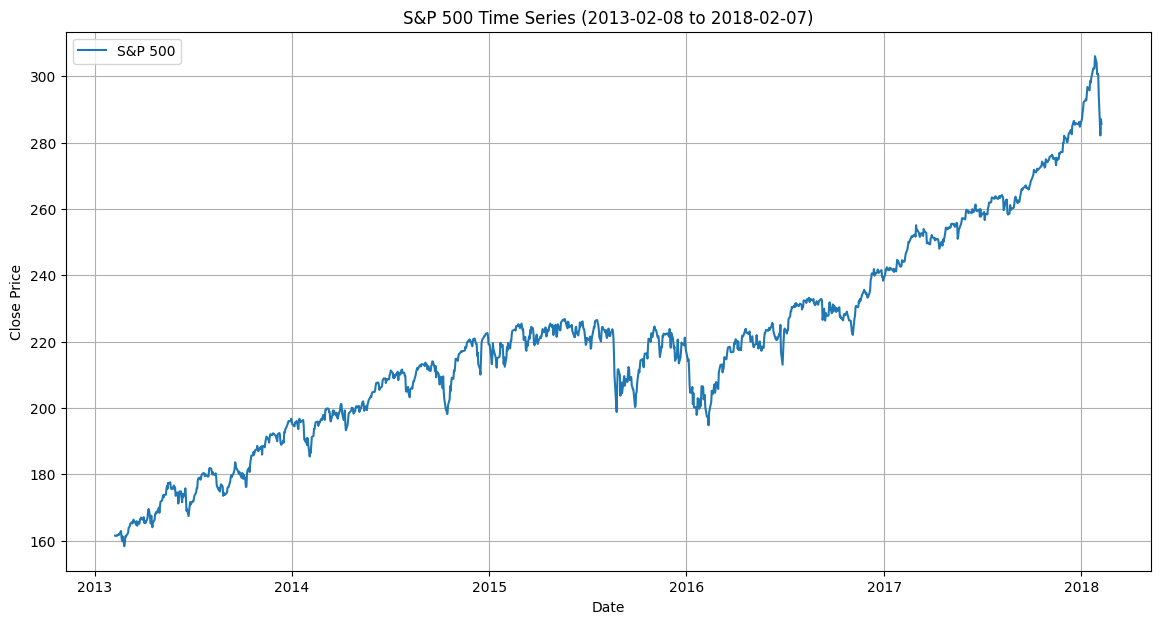

In [13]:
# Filter data for the specific dates
start_date = '2013-02-08'
end_date = '2018-02-07'
filtered_data = dataSNP[(dataSNP['Date'] >= start_date) & (dataSNP['Date'] <= end_date)]

# Plotting the time series for the column 'S&P_Price_Close'
plt.figure(figsize=(14, 7))
plt.plot(filtered_data['Date'], filtered_data['S&P_Price_Close'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Time Series (2013-02-08 to 2018-02-07)')
plt.legend()
plt.grid(True)
plt.show()


## Rolling Regression

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the Excel files
stock_file_path = '/content/stocks_data (1).xlsx'
index_file_path = '/content/PriceHistory_S&P500.xlsx'

# Load stock data
stock_data = pd.read_excel(stock_file_path, parse_dates=['date'])
stock_data.set_index('date', inplace=True)

# Load market index data
market_data = pd.read_excel(index_file_path, parse_dates=['Date'])
market_data.set_index('Date', inplace=True)

# Calculate log-returns for stocks
stock_data['log_return'] = np.log(stock_data['close'] / stock_data['close'].shift(1))

# Calculate log-returns for market index
market_data['log_return'] = np.log(market_data['S&P_Price_Close'] / market_data['S&P_Price_Close'].shift(1))

# Drop NA values created by log return calculation
stock_log_returns = stock_data.dropna(subset=['log_return'])
market_log_returns = market_data.dropna(subset=['log_return'])

# Function to perform rolling regression
def rolling_regression(y, x, window):
    params = [np.nan] * len(y)
    for i in range(window, len(y)):
        y_window = y[i-window:i]
        x_window = x[i-window:i]
        model = sm.OLS(y_window, sm.add_constant(x_window)).fit()
        params[i] = model.params[1]
    return params

# Set the rolling window size (180 trading days)
window_size = 180

# Dictionary to store rolling betas for each stock
rolling_betas = {}

# Get the unique stock names
stock_names = stock_data['Name'].unique()

# Perform rolling regression for each stock
for stock in stock_names:
    stock_returns = stock_log_returns[stock_log_returns['Name'] == stock]['log_return']
    # Ensure the market returns align with the stock returns index
    market_returns = market_log_returns['log_return'].reindex(stock_returns.index).dropna()

    # Align the indices
    aligned_index = stock_returns.index.intersection(market_returns.index)
    stock_returns = stock_returns.loc[aligned_index]
    market_returns = market_returns.loc[aligned_index]

    rolling_beta = rolling_regression(stock_returns, market_returns, window_size)
    rolling_betas[stock] = rolling_beta

# Convert rolling betas dictionary to a DataFrame
rolling_betas_df = pd.DataFrame(rolling_betas, index=stock_returns.index)

# Display the rolling betas DataFrame
print(rolling_betas_df.head())

# Plot the rolling betas for a specific stock (e.g., 'AAPL')
if 'AAPL' in rolling_betas_df.columns:
    rolling_betas_df['AAPL'].plot(figsize=(14, 7), title='Rolling Beta for AAPL (180-day window)')
    plt.xlabel('Date')
    plt.ylabel('Beta')
    plt.grid(True)
    plt.show()
else:
    print("AAPL data not available in the dataset")


ValueError: Length of values (1258) does not match length of index (1259)